Epoch 10/10 | E=-482.67 C=0.17353 Error=10.00%: 100%|██████████| 10/10 [00:48<00:00,  4.81s/epoch]


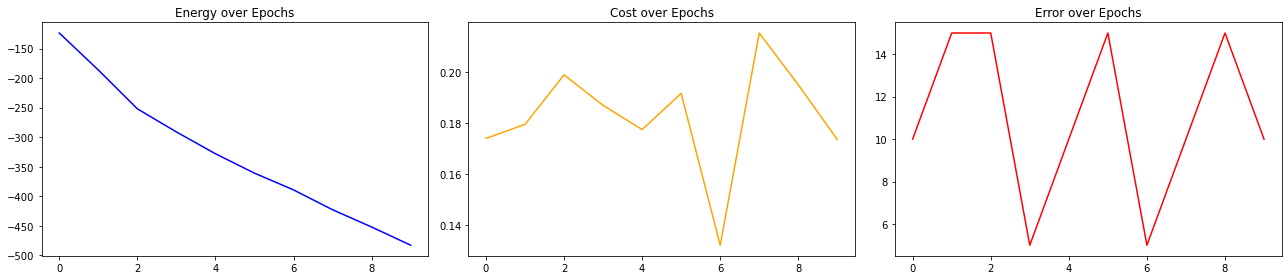

In [1]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

def plot_network_structure(net: Network):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # Add nodes explicitly with subset attribute
    for layer_idx, layer_label in enumerate(layer_labels):
        layer_size = net.weights[0].shape[0] if layer_idx == 0 else net.weights[layer_idx - 1].shape[1]
        for neuron_idx in range(layer_size):
            G.add_node((layer_label, neuron_idx), subset=layer_idx)

    # Add edges
    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                G.add_edge((layer_labels[idx], i), (layer_labels[idx + 1], j))

    pos = nx.multipartite_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, arrowsize=5)
    plt.title("Network Structure")
    plt.show()

def plot_network_weights(net: Network, epoch):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    for i, layer_size in enumerate([net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]):
        for n in range(layer_size):
            G.add_node((layer_labels[i], n), subset=i)

    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                weight = W[i, j].item()
                G.add_edge((layer_labels[idx], i), (layer_labels[idx+1], j), weight=weight)

    pos = nx.multipartite_layout(G, subset_key='subset')
    edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    plt.figure(figsize=(5, 2))
    
    # Normalize edge colors and explicitly create a ScalarMappable
    norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))
    cmap = plt.cm.RdYlGn

    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=norm.vmin, edge_vmax=norm.vmax, arrowsize=10)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='gray')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(edge_weights)
    plt.colorbar(sm, label='Weight magnitude', ax = plt.gca())

    plt.title(f"Network Structure at Epoch {epoch}")
    plt.axis('off')
    plt.show()


def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in range(epochs):
            for i in range(n_batches):
                net.update_mini_batch_index(i)
                net.negative_phase(n_it_neg)
                net.positive_phase(n_it_pos, *alphas)

            # Measure and log
            E, C, error = net.measure()
            history["Energy"].append(E)
            history["Cost"].append(C)
            history["Error"].append(error * 100)

            # Update progress bar description instead of using set_postfix()
            epoch_bar.set_description(f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} Error={error*100:.2f}%")
            epoch_bar.update(1)
            if(plot_graph):
                if epoch in snapshot_epochs:
                    plot_network_weights(net, epoch)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
        ax.plot(history[key], label=key, color=color)
        ax.set_title(f"{key} over Epochs")
    plt.tight_layout()
    plt.show()
net=Network(
        name="mnist", 
        external_world=MNISTExternalWorld(), 
        hyperparameters={
            "hidden_sizes": [1000],
            "n_epochs": 10,
            "batch_size": 20,
            "n_it_neg": 1,
            "n_it_pos": 1,
            "alphas": [np.float32(0.4), np.float32(0.1), np.float32(0.008)],
            "output_size": 10,
            "activation": "relu"
                                                                    }
    )
train_net(net)


# Double Inverse Model

## ReLU with backwards double normalization as well

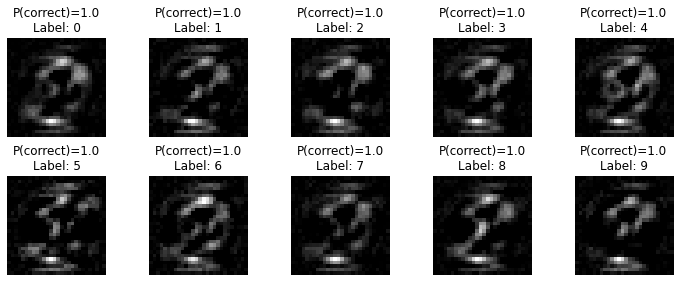

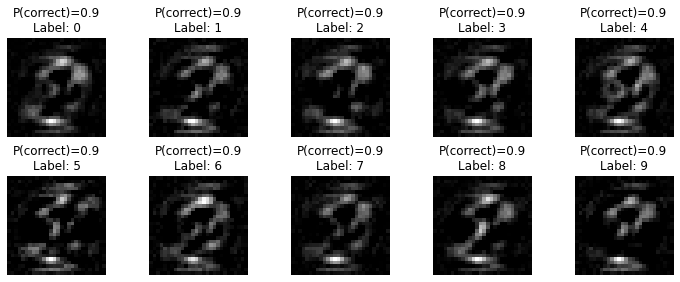

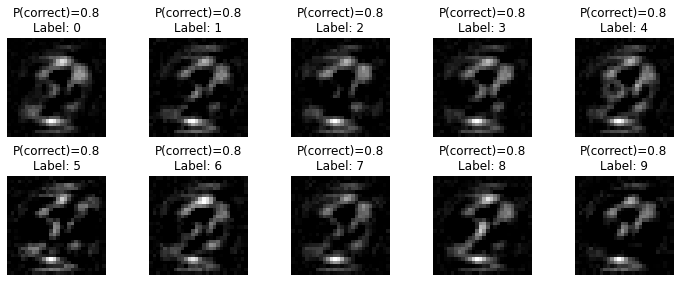

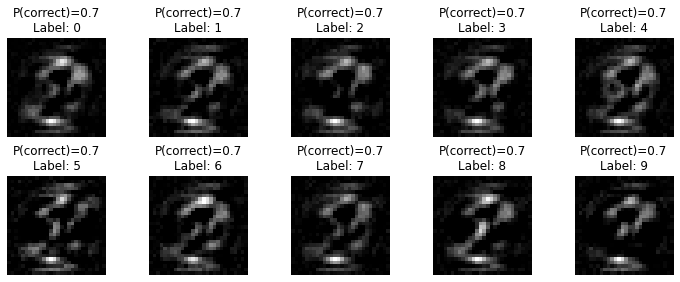

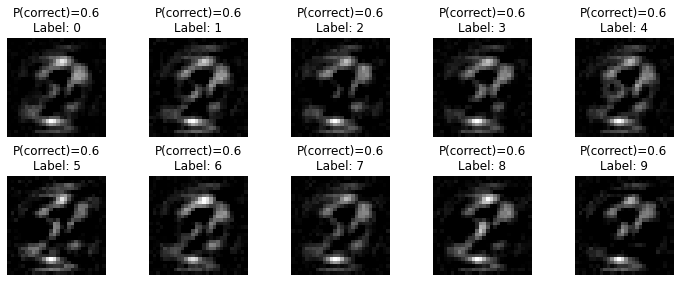

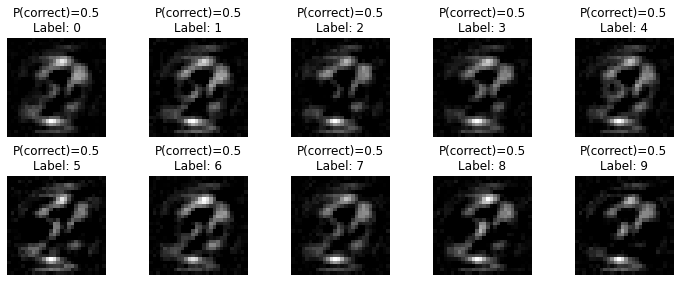

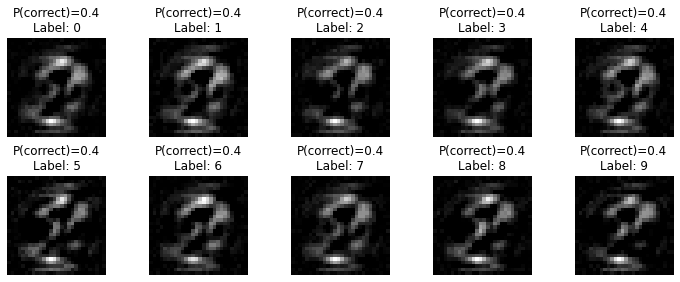

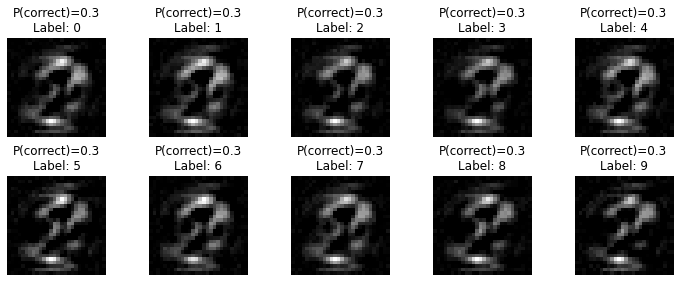

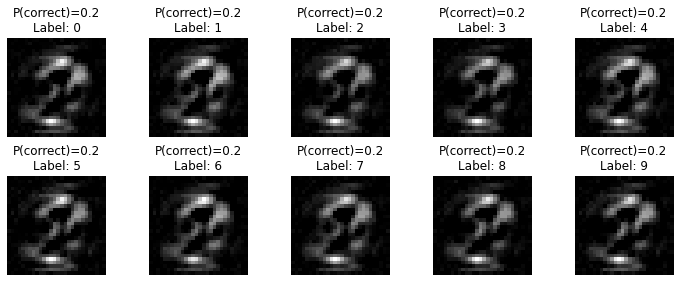

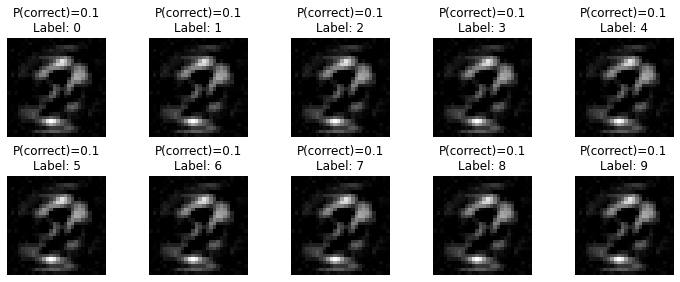

In [2]:
target = torch.zeros(10, 10)
# Generate images for probabilities from 1.0 down to 0.1
for prob in torch.arange(1.0, 0.0, -0.1):
    # Reset target tensor for 10 images
    target = torch.zeros(20, 10)
    
    # Set each image to target its corresponding number (0-9)
    for i in range(10):
        # Set the target probability for correct class
        target[i,i] = prob
        
        # Distribute remaining probability evenly among incorrect classes
        remaining_prob = (1.0 - prob) / 9
        for j in range(10):
            if j != i:
                target[i,j] = remaining_prob
                
    # Generate images using reverse inference

    regen_input = net.backward(target, 10)
    
    # Plot the regenerated images
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img, label in zip(axes.flatten(), regen_input, target):
        ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
        ax.set_title(f'P(correct)={prob:.1f}\nLabel: {label.argmax().item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## ReLu with double normalization

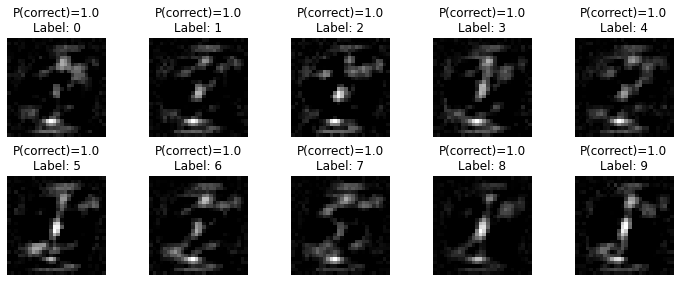

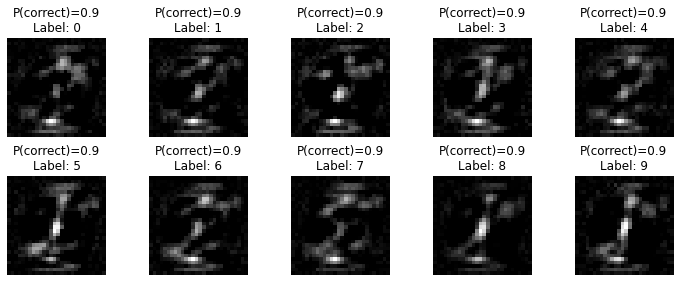

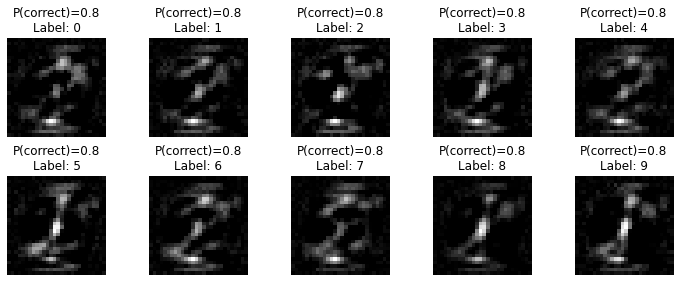

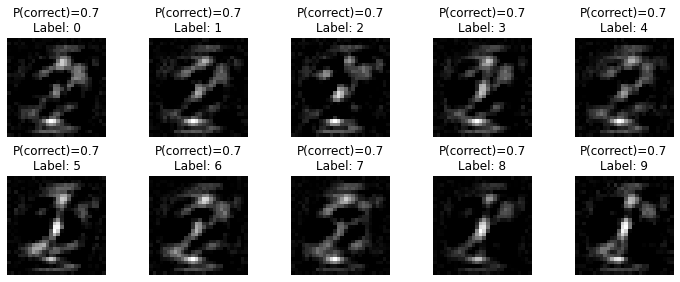

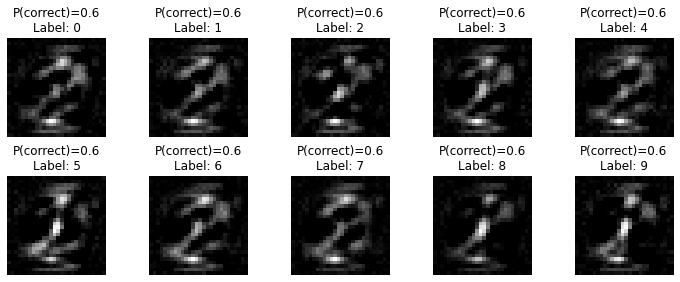

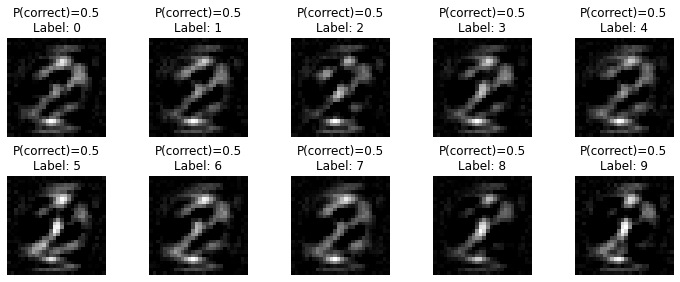

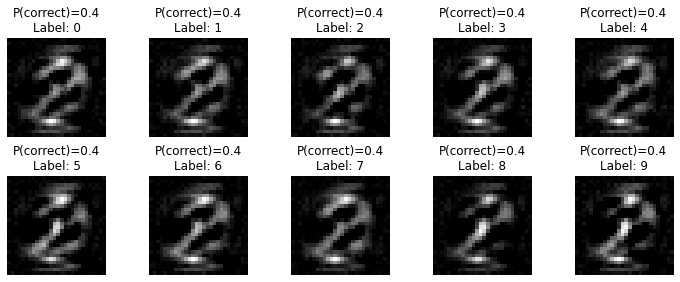

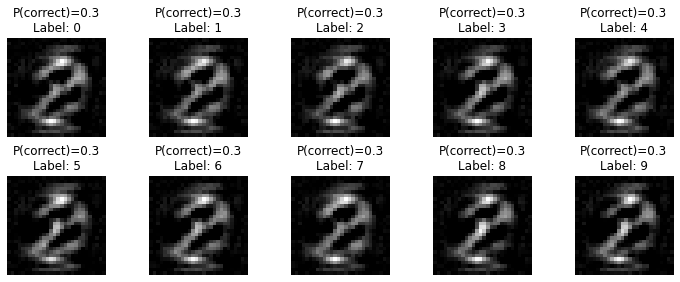

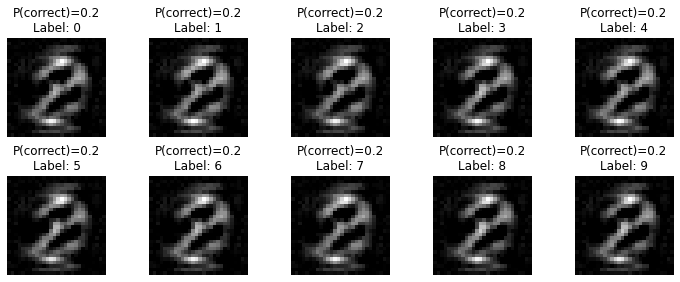

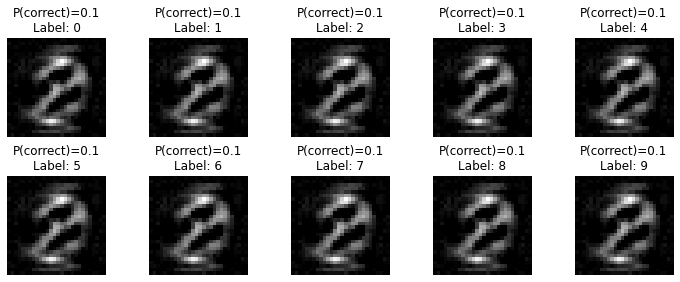

In [2]:
target = torch.zeros(10, 10)
# Generate images for probabilities from 1.0 down to 0.1
for prob in torch.arange(1.0, 0.0, -0.1):
    # Reset target tensor for 10 images
    target = torch.zeros(20, 10)
    
    # Set each image to target its corresponding number (0-9)
    for i in range(10):
        # Set the target probability for correct class
        target[i,i] = prob
        
        # Distribute remaining probability evenly among incorrect classes
        remaining_prob = (1.0 - prob) / 9
        for j in range(10):
            if j != i:
                target[i,j] = remaining_prob
                
    # Generate images using reverse inference

    regen_input = net.backward(target, 10)
    
    # Plot the regenerated images
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img, label in zip(axes.flatten(), regen_input, target):
        ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
        ax.set_title(f'P(correct)={prob:.1f}\nLabel: {label.argmax().item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Pi with backward batch norm as well

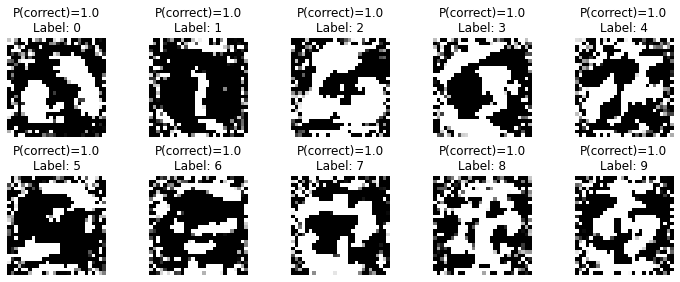

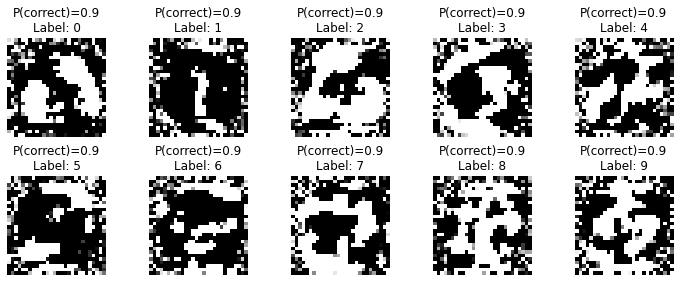

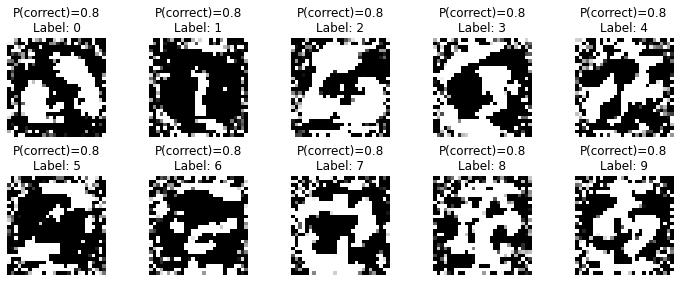

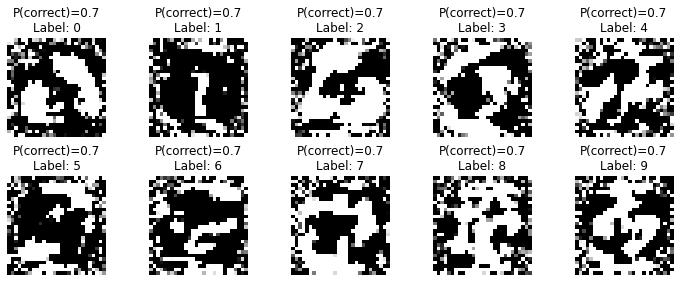

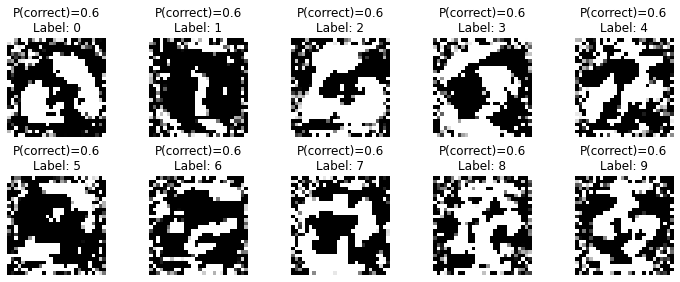

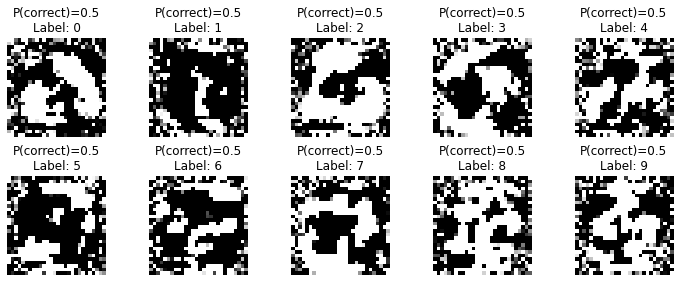

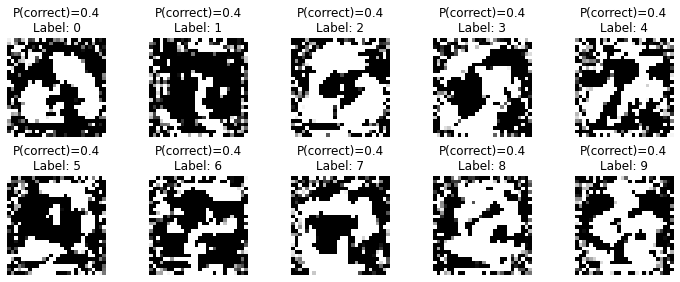

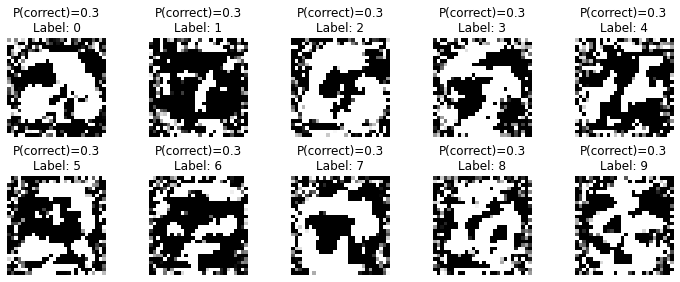

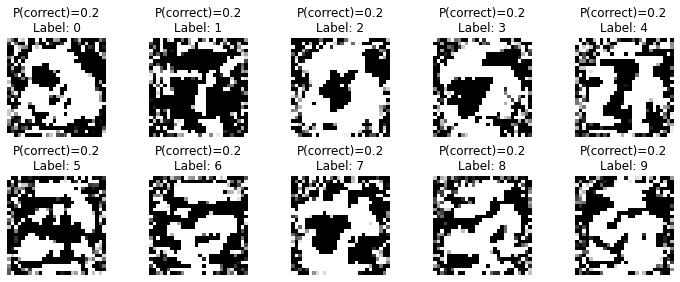

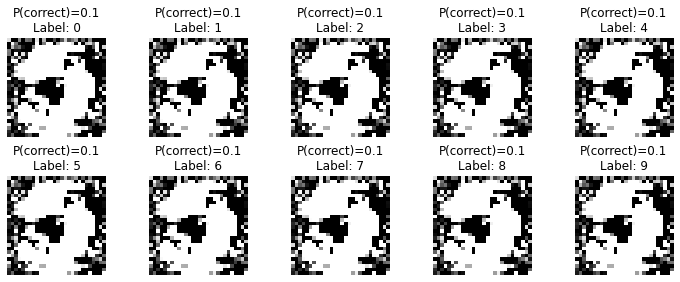

In [2]:
target = torch.zeros(10, 10)
# Generate images for probabilities from 1.0 down to 0.1
for prob in torch.arange(1.0, 0.0, -0.1):
    # Reset target tensor for 10 images
    target = torch.zeros(20, 10)
    
    # Set each image to target its corresponding number (0-9)
    for i in range(10):
        # Set the target probability for correct class
        target[i,i] = prob
        
        # Distribute remaining probability evenly among incorrect classes
        remaining_prob = (1.0 - prob) / 9
        for j in range(10):
            if j != i:
                target[i,j] = remaining_prob
                
    # Generate images using reverse inference

    regen_input = net.backward(target, 10)
    
    # Plot the regenerated images
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img, label in zip(axes.flatten(), regen_input, target):
        ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
        ax.set_title(f'P(correct)={prob:.1f}\nLabel: {label.argmax().item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

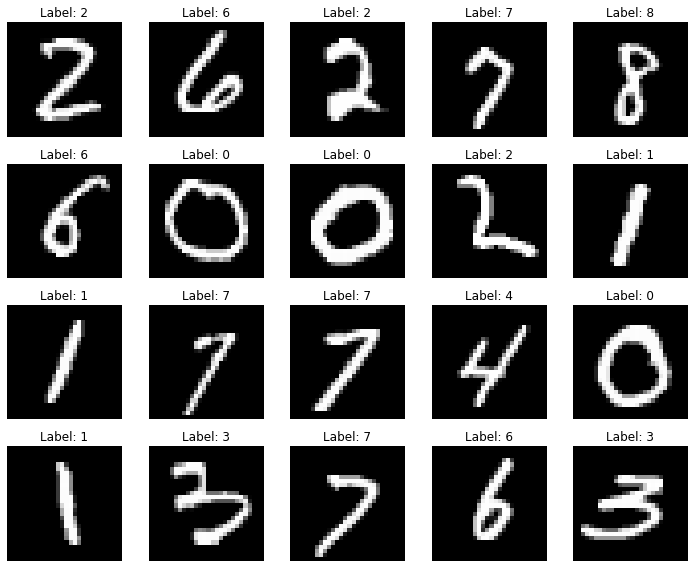

torch.Size([20, 784])
Energy:  -310.677001953125
Cost:  0.005007604882121086
Error:  0.005000000074505806
Output class:  tensor([2, 6, 2, 7, 8, 6, 2, 0, 0, 1, 1, 7, 7, 4, 0, 1, 3, 7, 6, 3])
Input class:  tensor([2, 6, 2, 7, 8, 6, 0, 0, 2, 1, 1, 7, 7, 4, 0, 1, 3, 7, 6, 3])


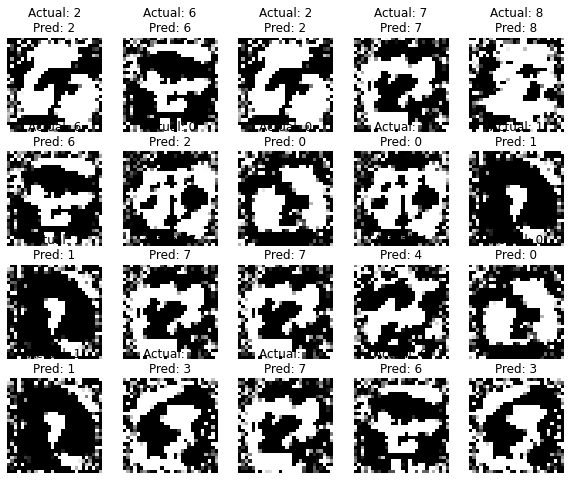

In [3]:
# MNIST Dataloader 
# Create a DataLoader for MNIST dataset
mnist_world = MNISTExternalWorld()
batch_size = 32
mnist_data = torch.utils.data.TensorDataset(mnist_world.x, mnist_world.y)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

# Randomly select 20 images from the dataloader
random_indices = torch.randperm(len(mnist_loader.dataset))[:20]
selected_images = mnist_loader.dataset[random_indices]

# Plot the selected images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
(img_all, label_all) = selected_images[0],selected_images[1]
img_all = img_all.reshape(20,-1)
for ax, img, label in zip(axes.flatten(), img_all, label_all):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Pass the selected images through the network

En, Cn, error = net.forward((img_all, label_all),10)

# Print the output labels
print("Energy: ", En)
print("Cost: ", Cn)
print("Error: ", error)

# Get the class of the output labels
output = net.layers[-1]
output_class = torch.argmax(output, dim=1)
print("Output class: ", output_class)

# Get the class of the input labels
input_class = label_all
print("Input class: ", input_class)

# Backward the output labels
backward_output = net.backward(output)

# Plot the backward output
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, actual, pred in zip(axes.flatten(), backward_output, input_class, output_class):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Actual: {actual.item()}\nPred: {pred.item()}')
    ax.axis('off')


## Pi with only batch norm

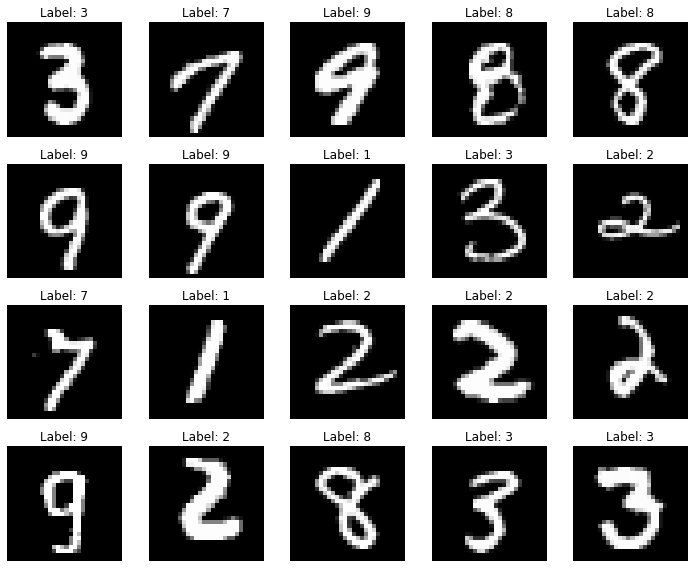

torch.Size([20, 784])
Energy:  -285.1134521484375
Cost:  0.010133080184459686
Error:  0.010000000149011612
Output class:  tensor([3, 7, 0, 8, 8, 9, 9, 1, 3, 0, 7, 1, 2, 2, 0, 9, 5, 8, 3, 3])
Input class:  tensor([3, 7, 9, 8, 8, 9, 9, 1, 3, 2, 7, 1, 2, 2, 2, 9, 2, 8, 3, 3])


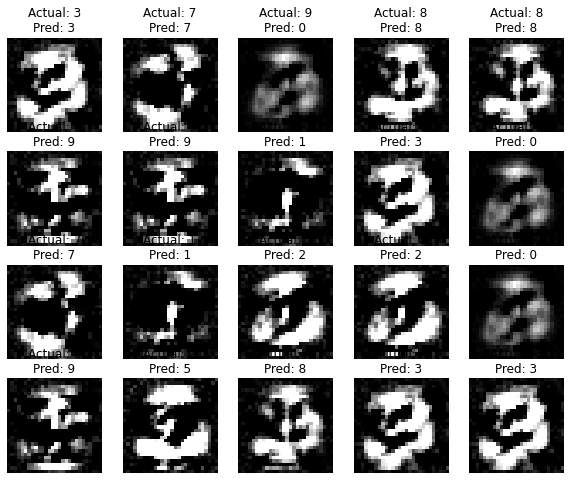

In [2]:
# MNIST Dataloader 
# Create a DataLoader for MNIST dataset
mnist_world = MNISTExternalWorld()
batch_size = 32
mnist_data = torch.utils.data.TensorDataset(mnist_world.x, mnist_world.y)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

# Randomly select 20 images from the dataloader
random_indices = torch.randperm(len(mnist_loader.dataset))[:20]
selected_images = mnist_loader.dataset[random_indices]

# Plot the selected images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
(img_all, label_all) = selected_images[0],selected_images[1]
img_all = img_all.reshape(20,-1)
for ax, img, label in zip(axes.flatten(), img_all, label_all):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Pass the selected images through the network

En, Cn, error = net.forward((img_all, label_all),10)

# Print the output labels
print("Energy: ", En)
print("Cost: ", Cn)
print("Error: ", error)

# Get the class of the output labels
output = net.layers[-1]
output_class = torch.argmax(output, dim=1)
print("Output class: ", output_class)

# Get the class of the input labels
input_class = label_all
print("Input class: ", input_class)

# Backward the output labels
backward_output = net.backward(output)

# Plot the backward output
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, actual, pred in zip(axes.flatten(), backward_output, input_class, output_class):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Actual: {actual.item()}\nPred: {pred.item()}')
    ax.axis('off')




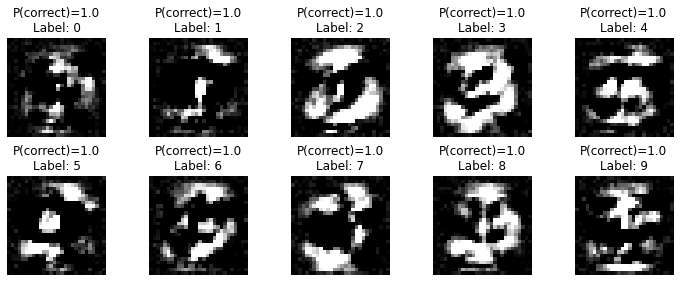

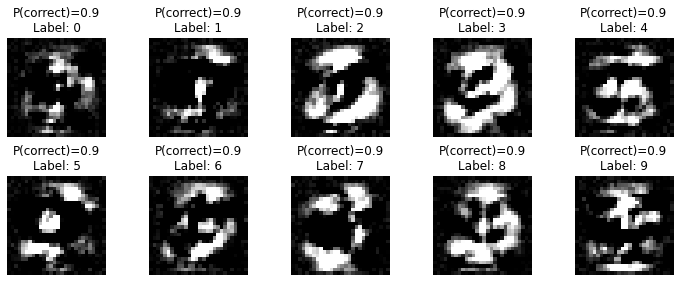

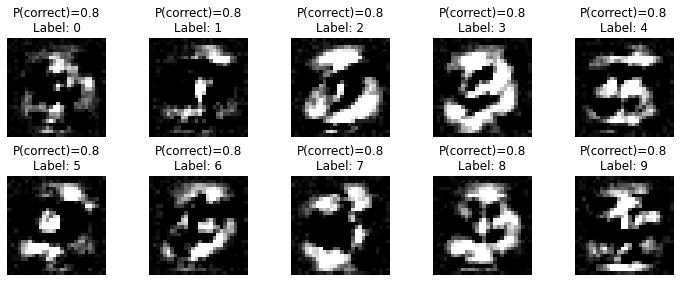

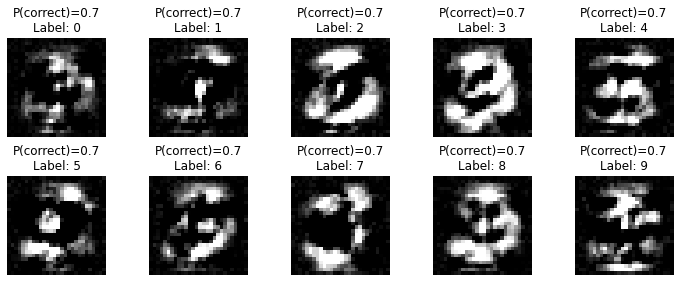

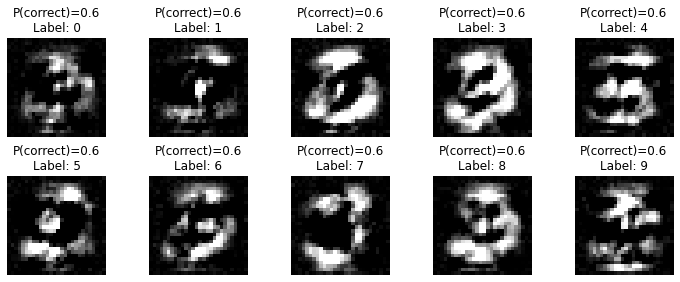

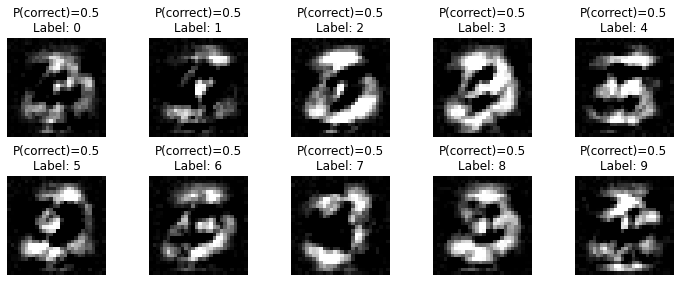

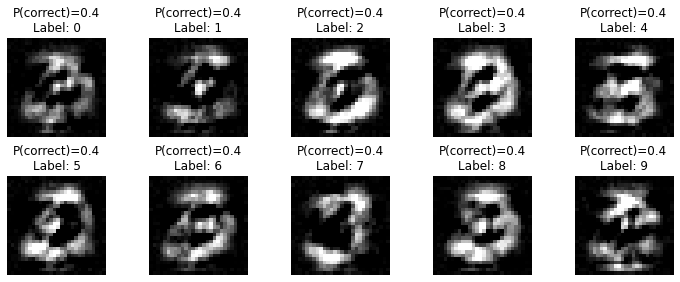

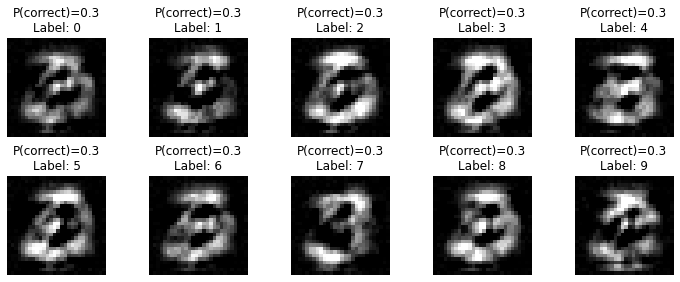

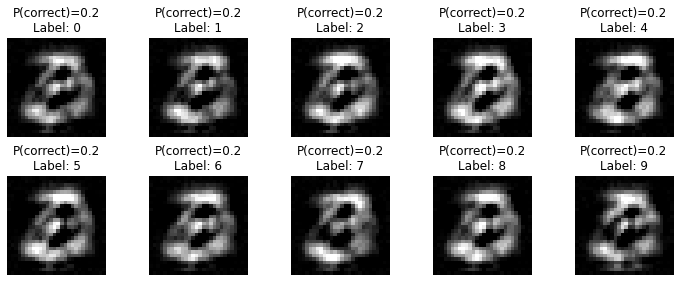

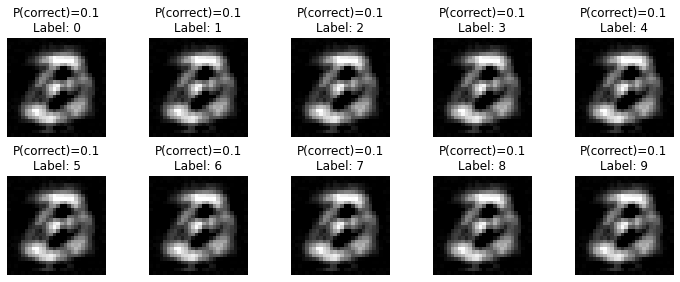

In [7]:
# For 3 and 4, generate inverse images by assigning a large probability to the correct class and a small probability to the incorrect classes. Start for probability 1 then backward pass and reduce probability by 0.1 each iteration until 0.1
target = torch.zeros(10, 10)
# Generate images for probabilities from 1.0 down to 0.1
for prob in torch.arange(1.0, 0.0, -0.1):
    # Reset target tensor for 10 images
    target = torch.zeros(20, 10)
    
    # Set each image to target its corresponding number (0-9)
    for i in range(10):
        # Set the target probability for correct class
        target[i,i] = prob
        
        # Distribute remaining probability evenly among incorrect classes
        remaining_prob = (1.0 - prob) / 9
        for j in range(10):
            if j != i:
                target[i,j] = remaining_prob
                
    # Generate images using reverse inference

    regen_input = net.backward(target, 10)
    
    # Plot the regenerated images
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for ax, img, label in zip(axes.flatten(), regen_input, target):
        ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
        ax.set_title(f'P(correct)={prob:.1f}\nLabel: {label.argmax().item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# Generate inverse images

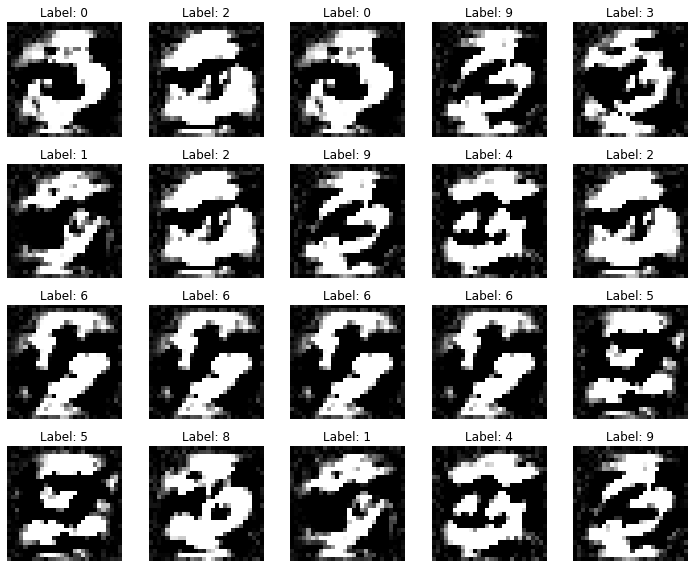

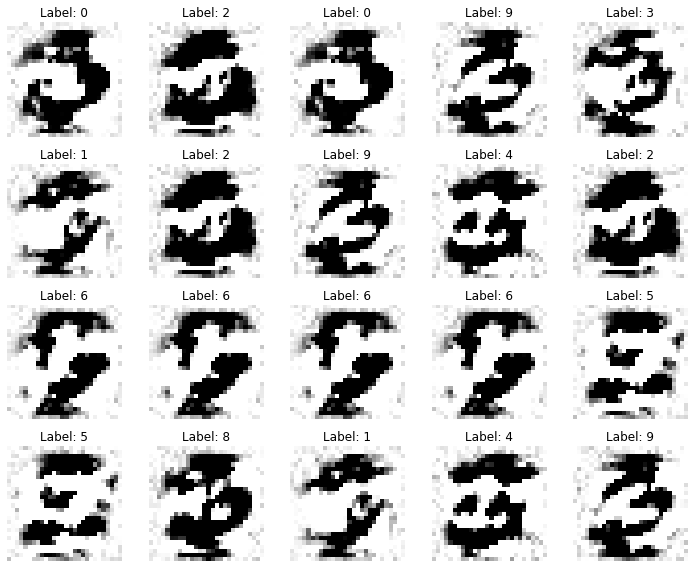

In [6]:
target = torch.zeros(20, 10) # 2500
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

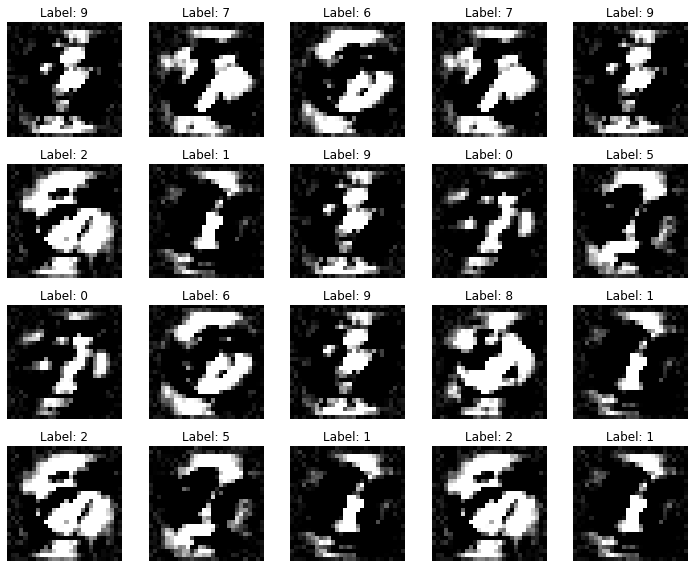

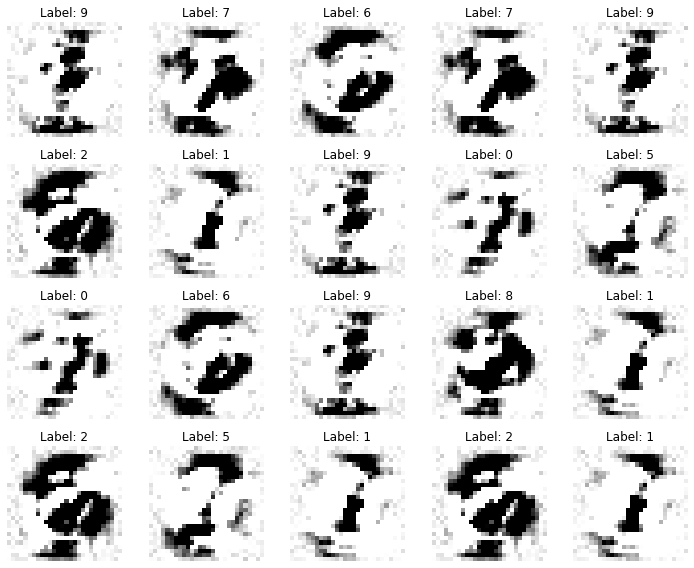

In [4]:
target = torch.zeros(20, 10)
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

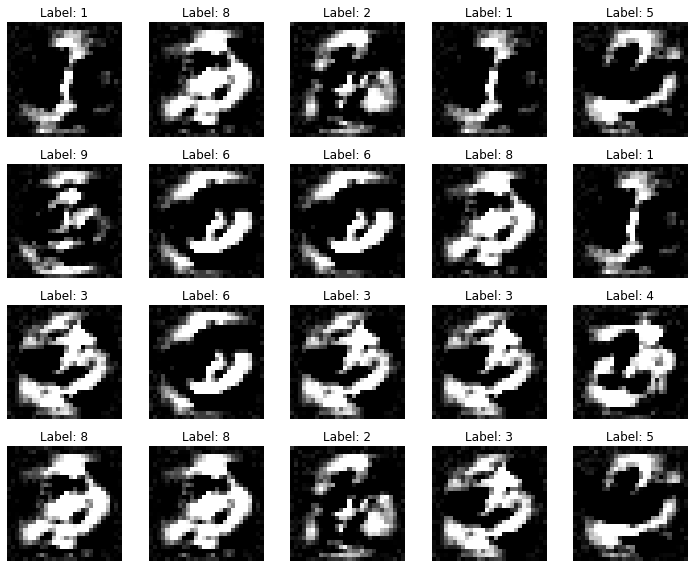

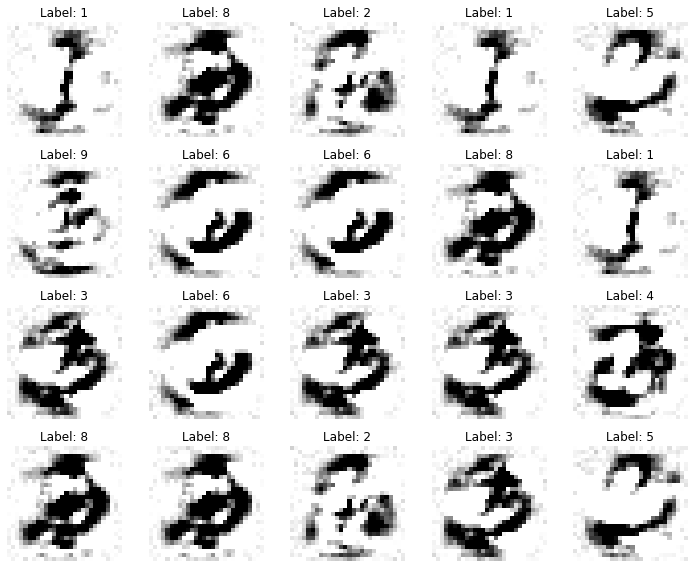

In [2]:
target = torch.zeros(20, 10)
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

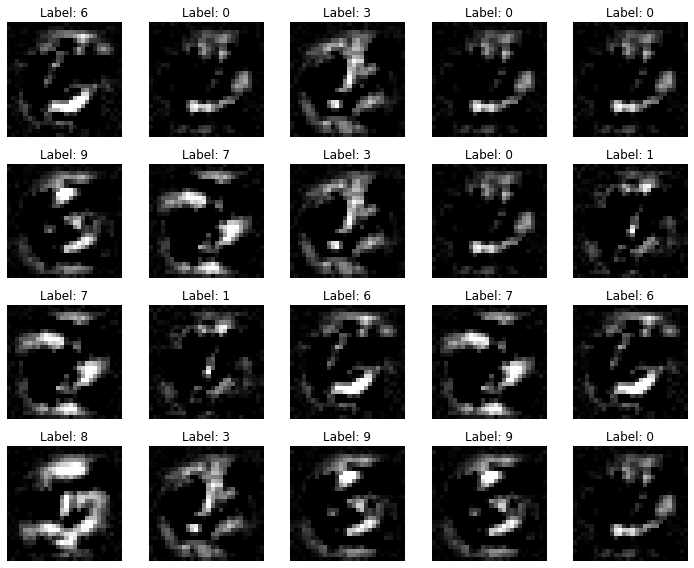

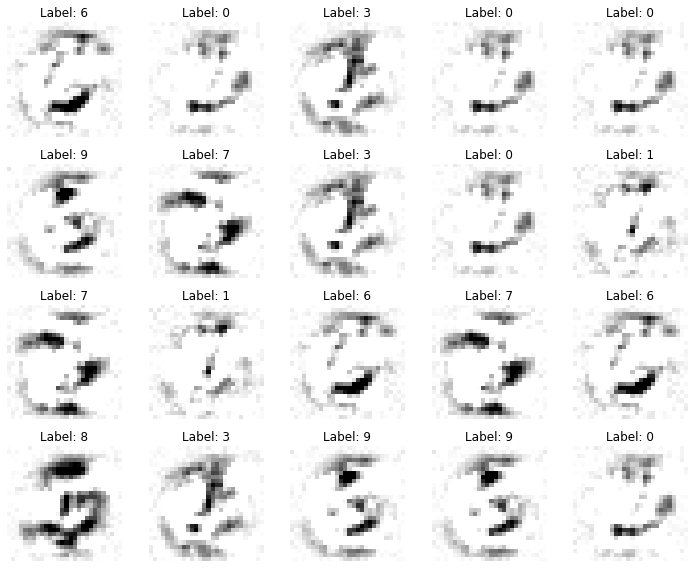

In [ ]:
# Generate 20 tensor such that each tensor is a 10x1 tensor with a 1 at a random index # Pi and batch normalization set at e1-5
# and zeros elsewhere
target = torch.zeros(20, 10)
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

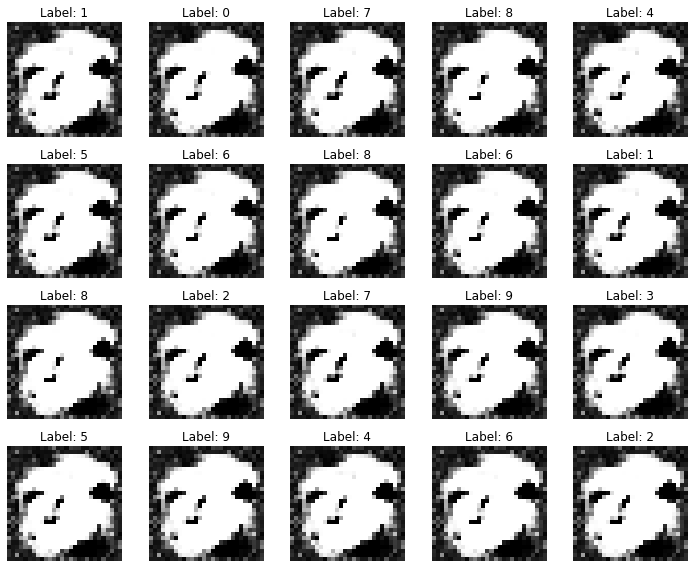

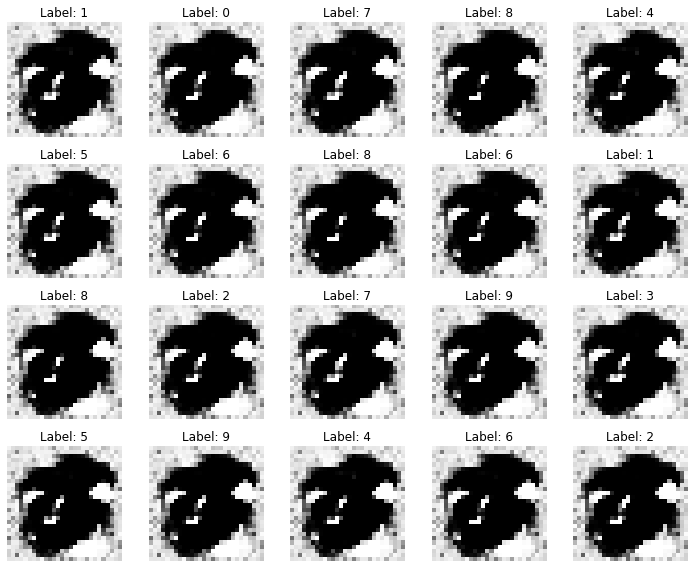

In [4]:
# Generate 20 tensor such that each tensor is a 10x1 tensor with a 1 at a random index
# and zeros elsewhere
target = torch.zeros(20, 10)
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

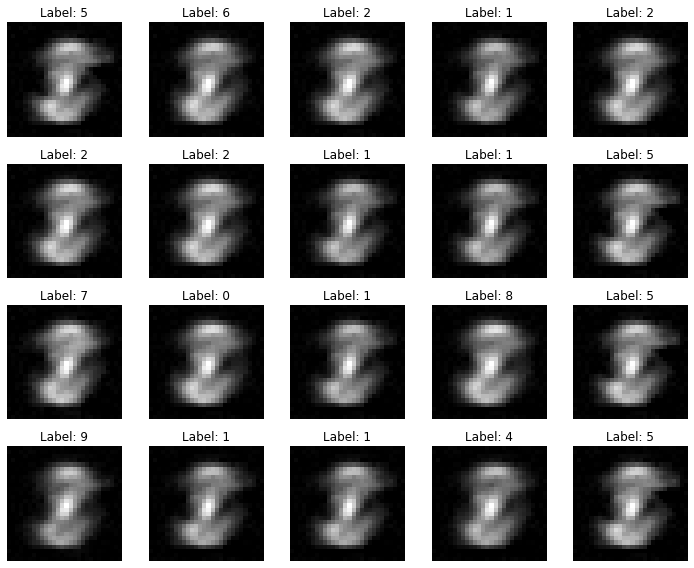

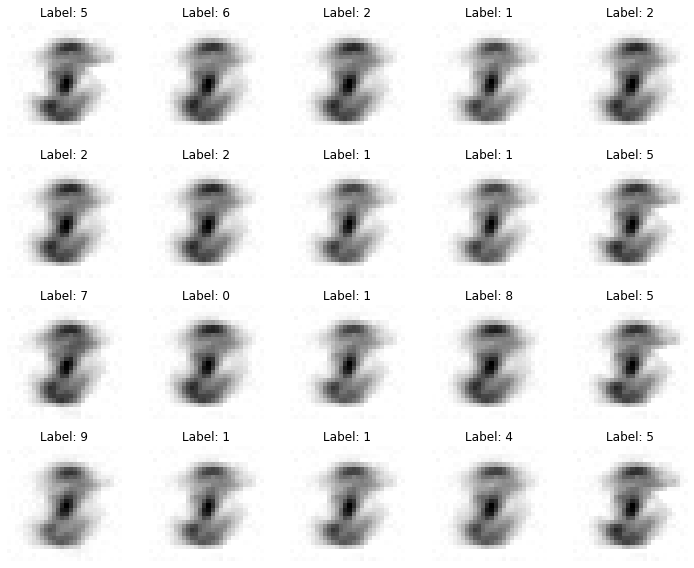

In [2]:
# Generate 20 tensor such that each tensor is a 10x1 tensor with a 1 at a random index
# and zeros elsewhere
target = torch.zeros(20, 10)
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


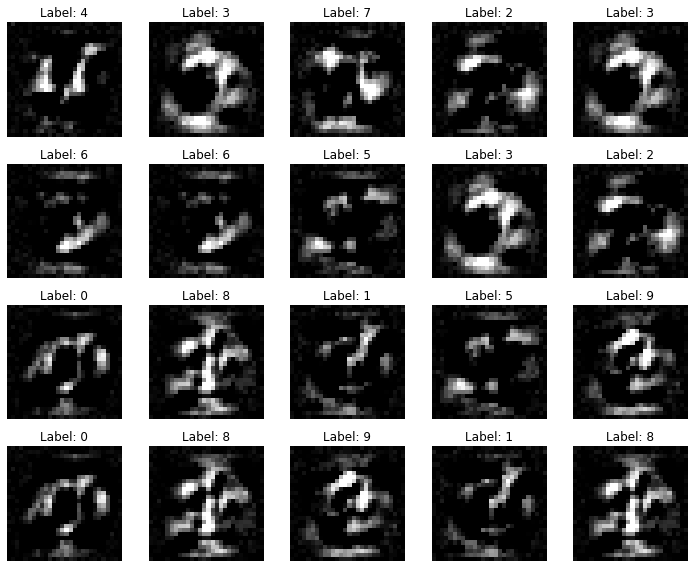

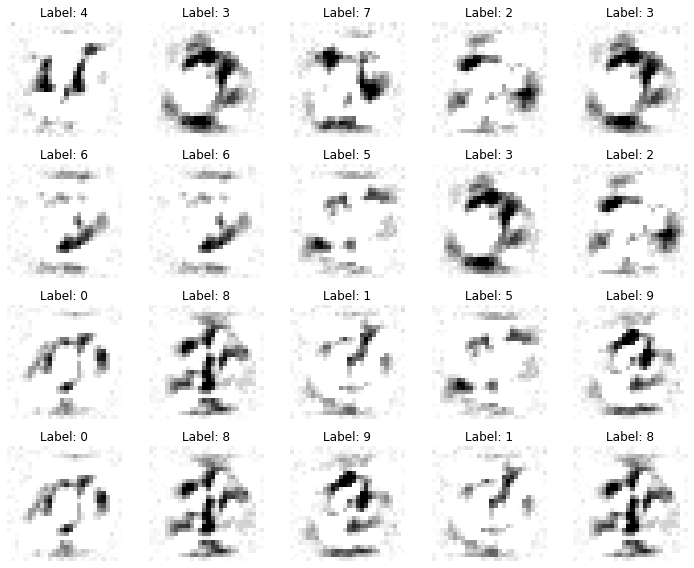

In [4]:
# Generate 20 tensor such that each tensor is a 10x1 tensor with a 1 at a random index
# and zeros elsewhere
target = torch.zeros(20, 10)
target[torch.arange(20), torch.randint(0, 10, (20,))] = 1
regen_input = net.reverse_infer(target,10)
# Plot the regenerated images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
# For the above generated images, reverse the color of the image
regen_input = 1 - regen_input
# Plot the reversed images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for ax, img, label in zip(axes.flatten(), regen_input, target):
    ax.imshow(img.view(28, 28).detach().numpy(), cmap='gray')
    ax.set_title(f'Label: {label.argmax().item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()
